In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

import numpy as np
import matplotlib.pyplot as plt 

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
np.random.seed(42)
x = np.random.rand(100,1)
y = 1 + 2* x + 0.1 * np.random.rand(100, 1)
N = 80
x_train, y_train = x[:N], y[:N]
x_test, y_test = x[N:], y[N:]

In [4]:
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())


<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


In [5]:
#FIRST
a = torch.randn(1, requires_grad = True, dtype = torch.float)
b = torch.randn(1, requires_grad = True, dtype = torch.float)
print(a, b)
#Second
a = torch.randn(1, requires_grad = True, dtype = torch.float).to(device)
b = torch.randn(1, requires_grad = True, dtype = torch.float).to(device)
print(a, b)
# Third
a = torch.randn(1,  dtype = torch.float).to(device)
b = torch.randn(1, dtype = torch.float).to(device)
a.requires_grad_()
b.requires_grad_()
print(a,b)

tensor([0.1681], requires_grad=True) tensor([0.2846], requires_grad=True)
tensor([-0.2844], device='cuda:0', grad_fn=<CopyBackwards>) tensor([-0.6401], device='cuda:0', grad_fn=<CopyBackwards>)
tensor([-1.6705], device='cuda:0', requires_grad=True) tensor([-0.0494], device='cuda:0', requires_grad=True)


Every method that ends with underscore ( _ ) makes change in-place

In [6]:
# Forth. The best method
a = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
b = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
print(a, b)

tensor([2.0396], device='cuda:0', requires_grad=True) tensor([-0.1836], device='cuda:0', requires_grad=True)


In [7]:
lr = 1e-1
n_epochs = 1000
torch.manual_seed(42)
a = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
b = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error**2).mean()
    loss.backward()
    #print(a.grad)
    #print(b.grad)
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    a.grad.zero_()
    b.grad.zero_()
print(a, b)


tensor([1.0482], device='cuda:0', requires_grad=True) tensor([1.9983], device='cuda:0', requires_grad=True)


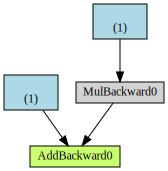

In [8]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad = True, dtype = torch.float, device= device)
b = torch.randn(1, requires_grad = True, dtype = torch.float, device= device)
 
yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error**2).mean()
make_dot(yhat)

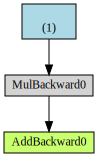

In [9]:
a_nograd = torch.randn(1, requires_grad = False, dtype = torch.float, device= device)
b = torch.randn(1, requires_grad = True, dtype = torch.float, device= device)

yhat = a_nograd + b * x_train_tensor
make_dot(yhat)

### Very good example about dynamical computational grapg in Pytorch
Это прямо очень крто, как мы можем между собой объединять различные losses
и вообще как мы можем всё это компоновать, это удивительно на самом деле. Теперь я понимаю почему его так любят, это по истине очень гибкая система. Мне кажется я её теперь тоже очень сильно полюблю


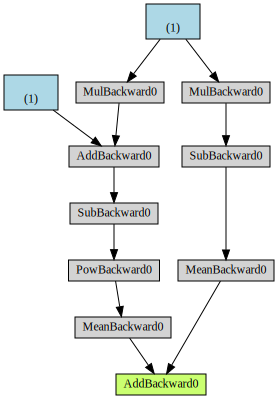

In [10]:
yhat = a + b * x_train_tensor
error = y_train_tensor - yhat

loss = (error**2).mean()
if loss >0:
    yhat2 = b* x_train_tensor
    error2 = y_train_tensor - yhat2
loss += error2.mean()
make_dot(loss)

In [11]:
# Now we implement another optimizer

torch.manual_seed(42)
a = torch.randn(1, requires_grad = True, dtype = torch.float, device= device)
b = torch.randn(1, requires_grad = True, dtype = torch.float, device= device)
print(" Parameters before updates via learning\n", a, b)
lr = 0.1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction = 'mean')
optimizer = optim.SGD([a, b], lr = lr)
for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    #No more it because it had implemented
    #error = y_train_tensor - yhat
    #loss = (error**2).mean()
    loss = loss_fn(y_train_tensor, yhat)
    
    loss.backward()
    # with torch.no_grad() NO MORE IT
    optimizer.step()
    optimizer.zero_grad()
    
print(" Parameters before updates via learning\n",a, b)

 Parameters before updates via learning
 tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)
 Parameters before updates via learning
 tensor([1.0482], device='cuda:0', requires_grad=True) tensor([1.9983], device='cuda:0', requires_grad=True)


### Let's go into model building

- Optimizer
- Loss
- Model

In [12]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()# initilize parent class
        # we need to send our model to the same device where the data is
        self.a = nn.Parameter(torch.randn(1, requires_grad = True, dtype = torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad = True, dtype = torch.float))   
        
    def forward(self, x):
        return self.a + self.b * x
    

In [13]:
torch.manual_seed(40)

model = ManualLinearRegression().to(device)
print(model.state_dict().values())

lr = 0.1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction = 'mean')
optimizer = optim.SGD(model.parameters(), lr = lr)

for epoch in range(n_epochs):
    
    model.train() # set our model in training mode
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()
    #print(loss)
    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

odict_values([tensor([0.9307], device='cuda:0'), tensor([-0.3482], device='cuda:0')])
OrderedDict([('a', tensor([1.0482], device='cuda:0')), ('b', tensor([1.9983], device='cuda:0'))])


#### Nested model

In [14]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1) # 1 input and 1 output
    def forward(self, x):
        return self.linear(x)

# Seconf approach more sequentialy
model  = nn.Sequential(nn.Linear(1,1).to(device))


In [15]:
# we want take our life better
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)         # make predict
        
        loss = loss_fn(y, yhat) #compute loss
        loss.backward()         #compute gradients
        
        optimizer.step()        #updates parameters
        otimizer.zero_grad()
        return loss.item()
    return train_step

# Creates the train_step func for certain our model
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

for epoch in range(n_epochs):
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
print(model.state_dict())

NameError: name 'otimizer' is not defined

## Focus in dataset
dataset in pytorch is represented by **Python class**

In [ ]:
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    def __len__(self):
        return len(self.x)

x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[1])

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[1])

Okey we know that we can create own dataset. It is very simple. And it is very good
But it save on operative memory and process by CPU
But we want on GPU. We can train downloading on GPU HOW
List below


### DataLoader

PyTorch DataLoader class for this job. We tell in which dataset to use. 
minibatch size, shuffle or not and so on


In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset = train_data, batch_size = 16, shuffle=True)
next(iter(train_loader))

In [ ]:
losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)

print(model.state_dict())


#### Random split

In [ ]:
from torch.utils.data.dataset import random_split
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(x).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80,20])
print(len(train_dataset), len(val_dataset))

train_loader = DataLoader(dataset = train_dataset, batch_size = 10)
val_loader = DataLoader(dataset = val_dataset, batch_size = 20)

In [ ]:
DataLoader?

In [ ]:
# good pipeline for training

losses = []
val_losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
    
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()
            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss)
            
            
print(model.state_dict())